# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Exploratory Data Analysis

In [2]:
raw_data = pd.read_excel('EMG_1_Subject_1.xlsx')
raw_data.sample(5)

,Emg1
116803,0.4346
60278,0.0366
434673,0.0024
254901,3.3447
44542,0.0269


In [3]:
raw_data.shape

(471483, 1)

In [4]:
raw_data.columns

Index(['Emg1'], dtype='object')

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471483 entries, 0 to 471482
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Emg1    471483 non-null  float64
dtypes: float64(1)
memory usage: 3.6 MB


In [6]:
raw_data.describe(include='all')

,Emg1
count,471483.000000
mean,0.129657
std,0.286859
min,0.002400
25%,0.002400
50%,0.017100
75%,0.114700
max,4.665500


https://analyticsindiamag.com/using-encoder-decoder-lstm-in-univariate-horizon-style-for-time-series-modelling/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.kaggle.com/code/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders/notebook

# Visualization

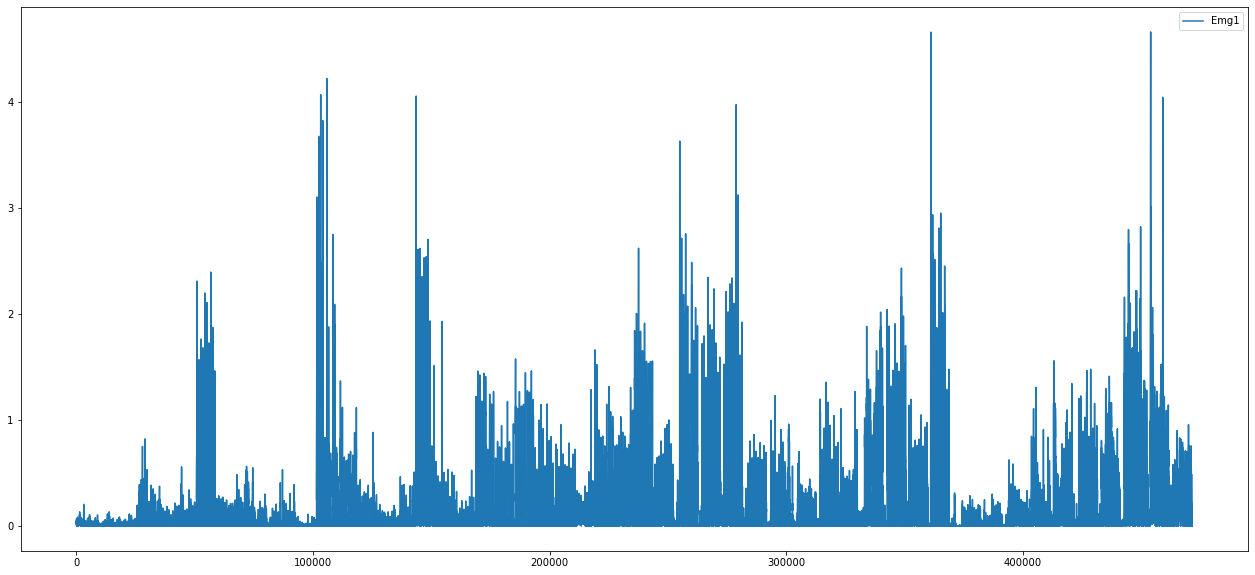

In [7]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(data=raw_data)

plt.show()

In [8]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler

In [9]:
dataset = raw_data


scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [10]:
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [12]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (466757, 10)
Shape of test set: (4704, 10)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [14]:
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')



###############################################
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14587/14587 [==============================] - 34s 2ms/step - loss: 3.4671e-05 - val_loss: 1.4271e-05
Epoch 2/5
14587/14587 [==============================] - 34s 2ms/step - loss: 2.0609e-05 - val_loss: 1.4840e-05
Epoch 3/5
14587/14587 [===

Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


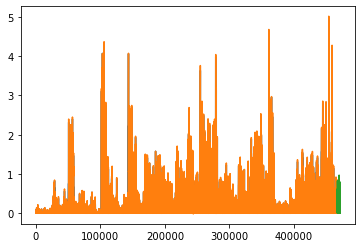

In [15]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
